# Geodesics on Planes

In this notebook, we try to find and illustrate geodesics on 2-D planes. For confidential reasons, our main goal is to find closed geodesics on a Möbius strip.

We assume to have a parametrization of these surfaces which embed them into 3-D euclidean space by the function
$$X: \mathbb R^2 \rightarrow \mathbb R^3, \; (u,v) \rightarrow (x,y,z).$$
For finding the geodesics, a semi-analytic approach is chosen: The plane parametrization and its derivates are symbolically treated, the evaluation of Christoffel symbols and solving of the geodaetic differential equation is performed numerically. This is in our view the most flexibel way.

We follow the definitions and formalism in [https://de.wikipedia.org/wiki/Christoffelsymbole] for the implementation of the following code.

## Helper Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.integrate
import scipy.optimize

from sympy import sin, cos, symbols, lambdify, Matrix, vector

In [2]:
def plot_surface(surface, line=None):
    fig = plt.figure(figsize=(13,13))
    ax = fig.add_subplot(projection='3d')
    
    surface = (np.squeeze(c) for c in surface) # unpack the coordinates X,Y,Z 
    ax.plot_wireframe(*surface, alpha=0.2)
    
    if line is not None: 
        line = (np.squeeze(c) for c in line)
        ax.plot(*line, color='red', linewidth=5)
    return ax

In [3]:
def geodesic(X, u_symbol, v_symbol, y0, tmax=10, solver_event=None):
    
    def Christoffel_Gamma(u, v):
        """calculates the Christoffel symbol value at point (u,v). Needs first- and 
        second-order derivatives of euclidean X coordantes (x,y,z) with respect to the 
        plane parameters / inner coordinates (u,v)"""

        # second derivates
        dX_du2 = dX_du2_num(u, v)
        dX_dv2 = dX_dv2_num(u, v)
        dX_dudv = dX_dudv_num(u, v)

        # first-order derivates and normal vector matrix
        dX_du = dX_du_num(u, v)
        dX_dv = dX_dv_num(u, v)
        N = np.cross(dX_du, dX_dv, axis=0) # normal vector
        dX_matrix = np.hstack([dX_du, dX_dv, N]) 

        # express second-order derivative in first-derivatives -> Christoffel symbol
        gamma_uu = np.linalg.solve(dX_matrix, dX_du2)[0:2]  # = \Gamma^k_uu, k=u or v
        gamma_uv = np.linalg.solve(dX_matrix, dX_dudv)[0:2] # = \Gamma^k_uv, k=u or v
        gamma_vv = np.linalg.solve(dX_matrix, dX_dv2)[0:2]  # = \Gamma^k_vv, k=u or v

        return (gamma_uu, gamma_uv, gamma_vv)

    
    def geodesic_equation(t, y):
        """Implements geodesic equation for ODE solver. Second-order eqn. are mapped to 
        system of first-order differential equations:  dy/dt = geodesic_eqn(t, y)

        t: parameter of line
        y:  = (u, u', v, v') with plane coordinates (u,v) and their derivatves
        """

        u, dudt, v, dvdt = y # state variables

        gamma_uu, gamma_uv, gamma_vv = Christoffel_Gamma(u, v)

        # Geodesic equation, see [https://de.wikipedia.org/wiki/Christoffelsymbole]:
        #  $$ u_k'' = -  \sum_ij gamma^k_ij * u'_i * u'_j  for all k $$
        # we use coordinates (u,v), these map to u_k with:  u_1 = u, u_2 = v

        du_dt2 = -(gamma_uu * dudt**2 + 2 * gamma_uv * dudt * dvdt + gamma_vv * dvdt**2)

        # return vector with derivatives (u', u'', v', v'')
        derivates =  np.array([dudt, du_dt2[0,0], dvdt, du_dt2[1,0]])
        return derivates

    
    u = u_symbol
    v = v_symbol 
    
    # symbolic first- and second-order derivatives
    dX_du = X.diff(u)
    dX_dv = X.diff(v)
    dX_du2 = X.diff(u,u)
    dX_dudv = X.diff(u, v)
    dX_dv2 = X.diff(v, v)

    # ... and their numerical functions
    X_num = lambdify((u, v), X, 'numpy')
    dX_du_num = lambdify((u, v), dX_du, 'numpy')
    dX_dv_num = lambdify((u, v), dX_dv, 'numpy')
    dX_du2_num = lambdify((u, v), dX_du2, 'numpy')
    dX_dudv_num = lambdify((u, v), dX_dudv, 'numpy')
    dX_dv2_num = lambdify((u, v), dX_dv2, 'numpy')
        
    sol = scipy.integrate.solve_ivp(geodesic_equation, [0, tmax], y0, dense_output=True,
                                    events=solver_event)
    
    # return the solver object if events were provided, otherwise only return function
    if solver_event:
        return sol
    else:
        return lambda t: sol.sol(t)[[0,2]]  # return u and v coordinate tuple only    

## Flat Plane in Polar Coordinates

Test the geodesics calculation on a flat surface defined with polar coordinates. We expect straight line :)

In [4]:
u, v = symbols('u v') # u = radius, v = angle phi

# Express euclidean coordinates (x,y,z) in terms of plane parameters (u,v)
X = Matrix([u * cos(v), 
            u * sin(v), 
            u * (cos(v) + sin(v))])

# first-order derivatives
dX_du = X.diff(u)
dX_dv = X.diff(v)

# ... and their numerical functions
X_num = lambdify((u, v), X, 'numpy')
dX_du_num = lambdify((u, v), dX_du, 'numpy')
dX_dv_num = lambdify((u, v), dX_dv, 'numpy')

X

Matrix([
[           u*cos(v)],
[           u*sin(v)],
[u*(sin(v) + cos(v))]])

Just for fun,  show plane, a curve and the phi and r coordinate gradients:

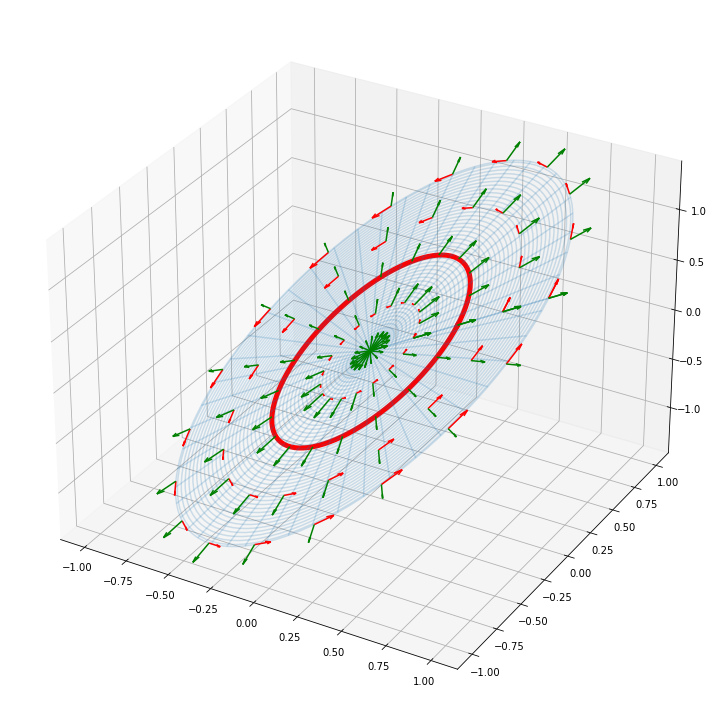

In [5]:
# calculate surface points for certain coordinate range
u_grid, v_grid = np.meshgrid(np.linspace(0, 1, 100), 
                             np.linspace(0, 2*np.pi, 100))
surface = X_num(u_grid, v_grid)

line = X_num(0.5, np.linspace(0, 2*np.pi, 100)) # define arbitrary line

# show gradients for fewer points
u_grid, v_grid = np.meshgrid(np.linspace(0, 1, 5), 
                             np.linspace(0, 2*np.pi, 20))
points = X_num(u_grid, v_grid)
vec = dX_du_num(u_grid, v_grid) /10
vec2 = dX_dv_num(u_grid, v_grid) /10

ax = plot_surface(surface, line)
ax.quiver3D(*(c for c in points), *(v for v in vec), color='green')
ax.quiver3D(*(c for c in points), *(v for v in vec2), color='red')

For sure, ithe red line is not a geodesic, so let's try to turn on the machinery...

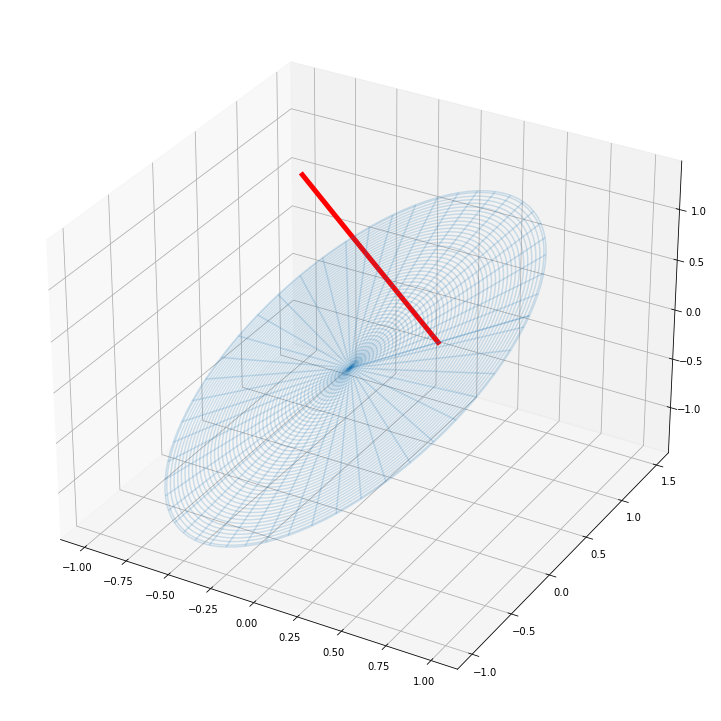

In [6]:
# solve the geodesic equation:
tmax = 3             # maximum length of line
y0 = [.5, -.5, 0, 1] # initial coordinates and derivatives (u, u', v, v'), determines direction and starting point
g = geodesic(X, u, v, y0, tmax)

# show it
t = np.linspace(0,tmax,100)
_ = plot_surface(surface, X_num(g(t)[0], g(t)[1]))

It looks like we have a straight line, ie. a geodesic in the flat plane! :-D

Let's have a look at the (u,v) coordinates of the geodesic. After all, they probably look more interesting...

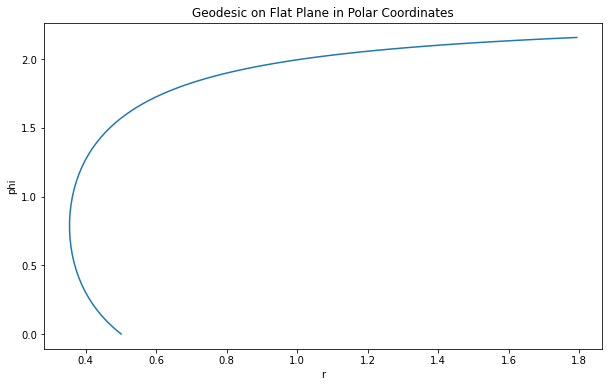

In [7]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()
ax.plot(g(t)[0], g(t)[1])
ax.set_xlabel('r')
ax.set_ylabel('phi')
_ = plt.title('Geodesic on Flat Plane in Polar Coordinates')

## Sphere

In [8]:
u, v = symbols('u v') # u = phi, v = angle theta

# Euclidean Mapping (u,v) -> (x,y,z)
R0 = 1
X = Matrix([R0 * cos(u)*sin(v), 
            R0 * sin(u)*sin(v), 
            R0 * cos(v)])

X_num = lambdify((u, v), X, 'numpy')

# calculate surface points for certain coordinate range
u_grid, v_grid = np.meshgrid(np.linspace(0, 2*np.pi, 100), 
                             np.linspace(0, np.pi, 100))
surface = X_num(u_grid, v_grid)

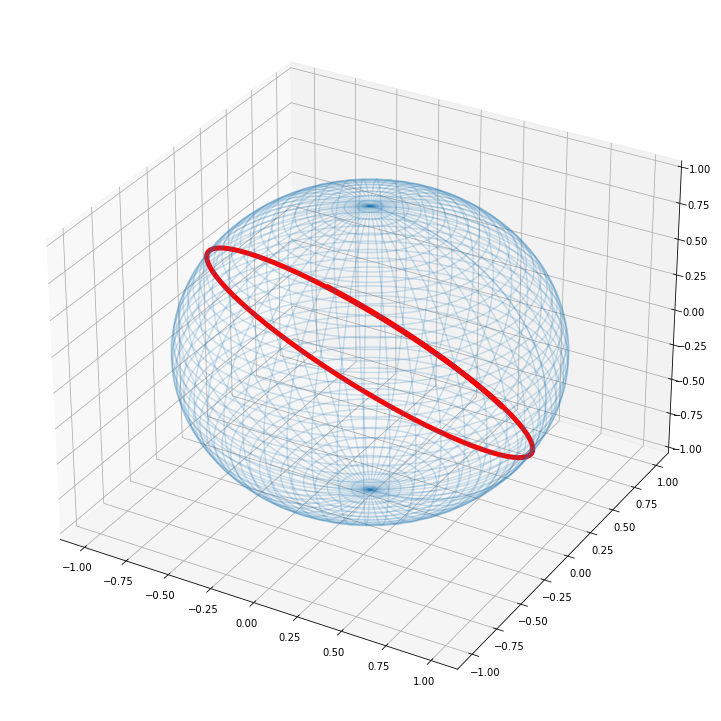

In [9]:
tmax = 10                  # maximum length of line
y0 = [1, 1, np.pi/2+.7, 0] # initial  u, u', v, v', determines direction and starting point
g = geodesic(X, u, v, y0, tmax)

# show it
t = np.linspace(0, tmax, 100)
_ = plot_surface(surface, X_num(g(t)[0], g(t)[1]))

Looks like a geodesic. Check!

## Torus

In [10]:
u, v = symbols('u v')
R0, R1 = 1, 0.25
X = Matrix([R0 * cos(u) + R1 * cos(u) * cos(v), 
            R0 * sin(u) + R1 * sin(u) * cos(v),
            R1 * sin(v)])

X_num = lambdify((u, v), X, 'numpy')

# calculate surface points
u_grid, v_grid = np.meshgrid(np.linspace(0, 2*np.pi, 100),
                             np.linspace(0, 2*np.pi, 100))
surface = X_num(u_grid, v_grid)

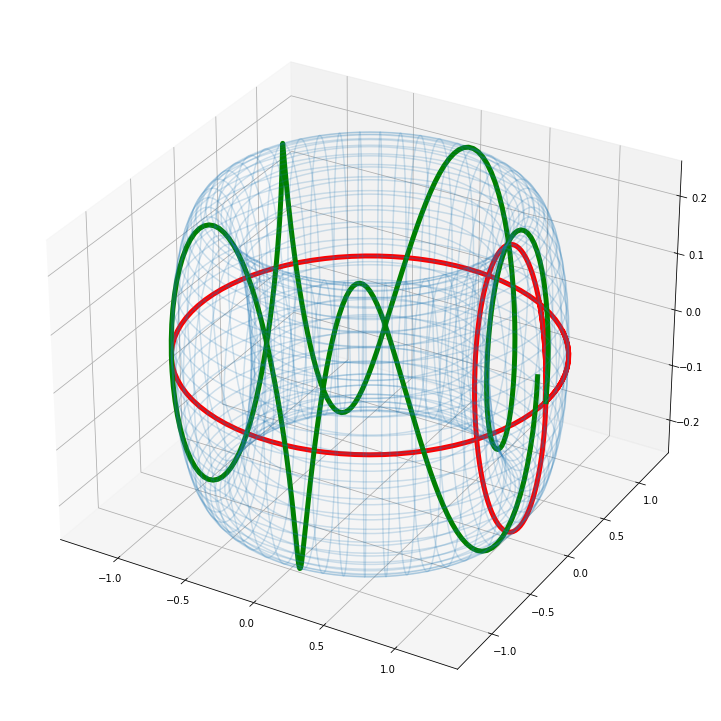

In [11]:
%matplotlib inline

tmax = 7
y0 = [0, 0, 0, 1] # point towards v coordinate
g = geodesic(X, u, v, y0, tmax)

t = np.linspace(0, tmax, 100)
ax = plot_surface(surface, X_num(g(t)[0], g(t)[1]))

# a different geodesic:  point towards u coordinate only
y0 = [0, 1, 0, 0] 
g = geodesic(X, u, v, y0, tmax)

line = X_num(g(t)[0], g(t)[1])
line = (np.squeeze(c) for c in line)
ax.plot(*line, color='red', linewidth=5)

# a third geodesic: inclined in both parameters
y0 = [0, .1, 0, 1]
tmax=35
g = geodesic(X, u, v, y0, tmax)

t = np.linspace(0, tmax, 300)
line = X_num(g(t)[0], g(t)[1])
line = (np.squeeze(c) for c in line)
ax.plot(*line, color='green', linewidth=5)

Looks like geodesics one would expect... Check! And now to the serious stuff:

## Cone

TODO, might look nice...

## Möbius Strip

In [12]:
u, v = symbols('u v')

R = 1
X = Matrix([(R + u * cos(0.5 * v)) * cos(v),
            (R + u * cos(0.5 * v)) * sin(v),
            u * sin(0.5 * v)])

X_num = lambdify((u, v), X, 'numpy')

# calculate surface points
u_grid, v_grid = np.meshgrid(np.linspace(-1, 1, 100),
                             np.linspace(0, 2*np.pi, 100))
surface = X_num(u_grid, v_grid)

X

Matrix([
[(u*cos(0.5*v) + 1)*cos(v)],
[(u*cos(0.5*v) + 1)*sin(v)],
[             u*sin(0.5*v)]])

## Closed Loop Geodesic
We don't want to find any geodesic, but a closed one. Therefore we need some preparations. Starting the geodesic at a point (u,v), we need to find the good direction to shoot if off, in order to hit the same point after roundtrip again:

In [36]:
tmax = 5      # max t parameter = max geodesic length
u_start = 0   # starting point u
v_start = 0   #   ... and  v

# define end coordinates which correspond to a closed loop
u_end_target = - u_start          # Möbius strip: u -> -u after one turn
v_end_target = v_start + 2*np.pi  # one single turn

In [37]:
def closed_loop_metric(du_dt):
    """Returns a measure of how good we got a closed loop given a du/dt starting direction."""
    
    def u_crossing_event(t, y):
        """Used in scipy.integrate.solve_ivp(event=) of geodesics() function, 
        used to detect target u values -> potential closed loop."""
        return (y[0] - u_end_target) 
   
    y0 = [u_start, du_dt, v_start, 1]  # fixed dv/dt=1 in order to go along strip
    g = geodesic(X, u, v, y0 , tmax, solver_event=u_crossing_event)
    
    #print(g.y_events)
    if len(g.y_events[0]) == 0:
        return 100
    
    # find v in events of u_end_target crossings, which is closest to v_end_target
    closest_idx = np.argmin(abs(g.y_events[0][:, 2] - v_end_target))
    u_end, v_end = g.y_events[0][closest_idx, [0,2]]
                            
    return (u_end_target - u_end)**2 + (v_end_target - v_end)**2

With that, we can searching optimal du/dt direction. (Set some starting point in the neighbourhood, which can be ound by studying geodesic (u,v) plots manually)


In [38]:
minimizer = scipy.optimize.minimize_scalar(closed_loop_metric, bracket=[-.7, -.8])
print(minimizer)
du_dt_closedloop = minimizer.x

     fun: 1.858195870232414e-14
    nfev: 23
     nit: 18
 success: True
       x: -1.5117115896979112


Let's have a look at this curve with the found du/dt value:

In [39]:
y0 = [u_start, du_dt_closedloop, v_start, 1]  # as defined in closed_loop_metric()
g = geodesic(X, u, v, y0, tmax)

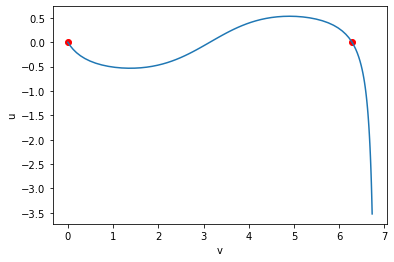

In [40]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel('v')
ax.set_ylabel('u')

# start and end point
ax.plot([v_start, v_end_target], [u_start, u_end_target], 'o', color='red')

t = np.linspace(0, tmax, 100)
line = (g(t)[1], g(t)[0])
ax.plot(*line)

<IPython.core.display.Javascript object>


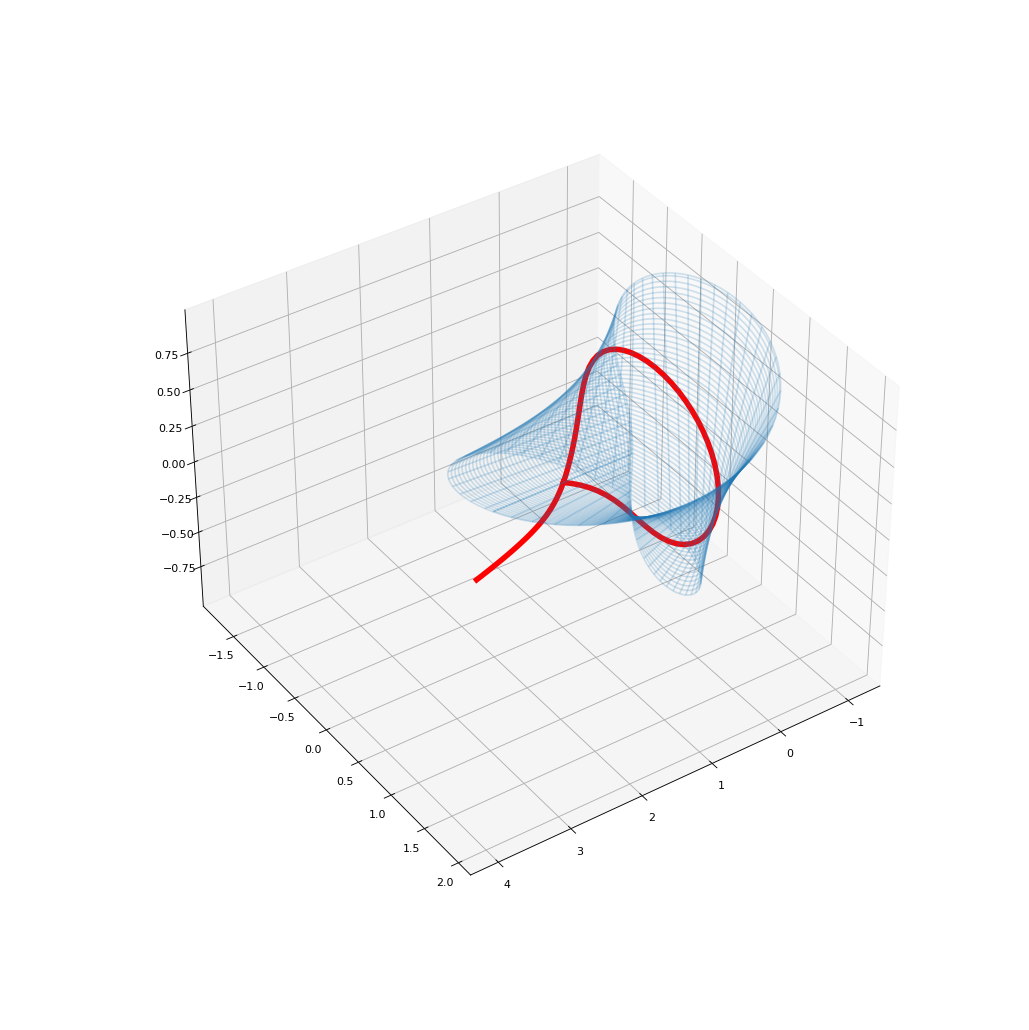

In [41]:
%matplotlib notebook
_ = plot_surface(surface, X_num(g(t)[0], g(t)[1]))

While we arrived at the same starting pint, the geodesics cuts itself at an angle and is not closed.

## Closed Geodesics, Take II

Experimenting with the initial values showed that (u,v)=(0,$\pi$) might yield better results:

In [28]:
tmax = 5      # max t parameter = max geodesic length
u_start = 0   # starting point u
v_start = np.pi   #   ... and  v

# define end coordinates which correspond to a closed loop
u_end_target = - u_start          # Möbius strip: u -> -u after one turn
v_end_target = v_start + 2*np.pi  # one single turn

Search optimal direction. ( See Experiments section below for chosen starting points 0.5, 0.51)


In [29]:
minimizer = scipy.optimize.minimize_scalar(closed_loop_metric, bracket=[0.5, 0.51])
print(minimizer)
du_dt_closedloop = minimizer.x

     fun: 4.4799798025093874e-13
    nfev: 25
     nit: 17
 success: True
       x: 0.6641064541349135


In [30]:
y0 = [u_start, du_dt_closedloop, v_start, 1]  # as defined in closed_loop_metric()
g = geodesic(X, u, v, y0, tmax)

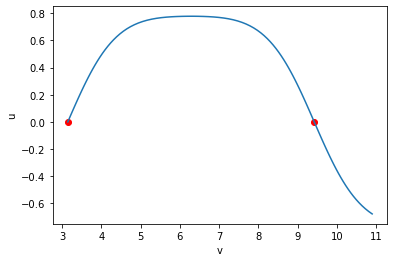

In [31]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel('v')
ax.set_ylabel('u')

# start and end point
ax.plot([v_start, v_end_target], [u_start, u_end_target], 'o', color='red')

t = np.linspace(0, tmax, 100)
line = (g(t)[1], g(t)[0])
ax.plot(*line)

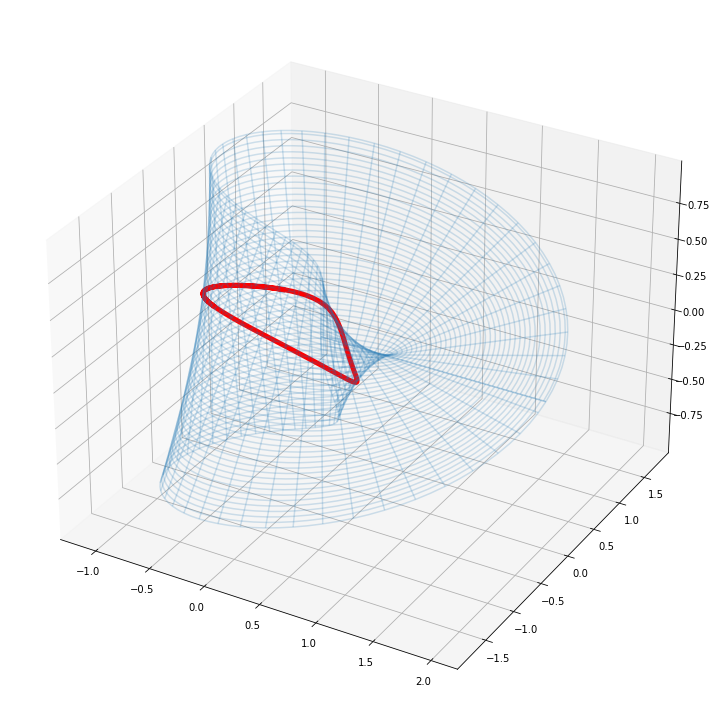

In [32]:
%matplotlib inline
_ = plot_surface(surface, X_num(g(t)[0], g(t)[1]))

Here we arrived at a properly closed geodesic on the Möbius strip. Other starting value for u_start might yield others as well.

## Annex: Experiments

<IPython.core.display.Javascript object>


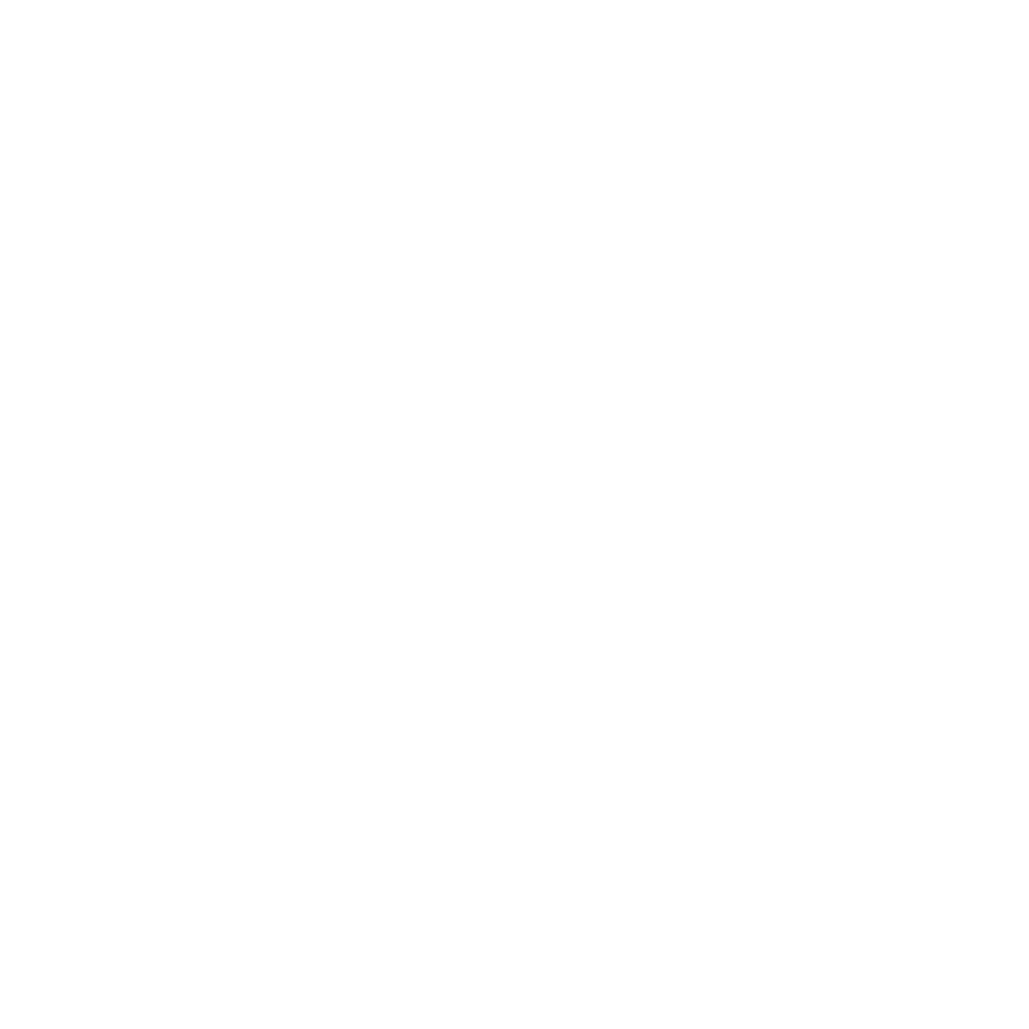

In [24]:
%matplotlib notebook


tmax = 1              # maximum length of line
t = np.linspace(0, tmax, 100)
ax = plot_surface(surface)

for du in np.linspace(0,-.2, 10):
    y0 = [0, du, 3*np.pi/4, 1] # initial  u, u', v, v', determines direction and starting point
    g = geodesic(X, u, v, y0, tmax)
    
    line = X_num(g(t)[0], g(t)[1])
    line = (np.squeeze(c) for c in line)
    ax.plot(*line, color='red', linewidth=5)


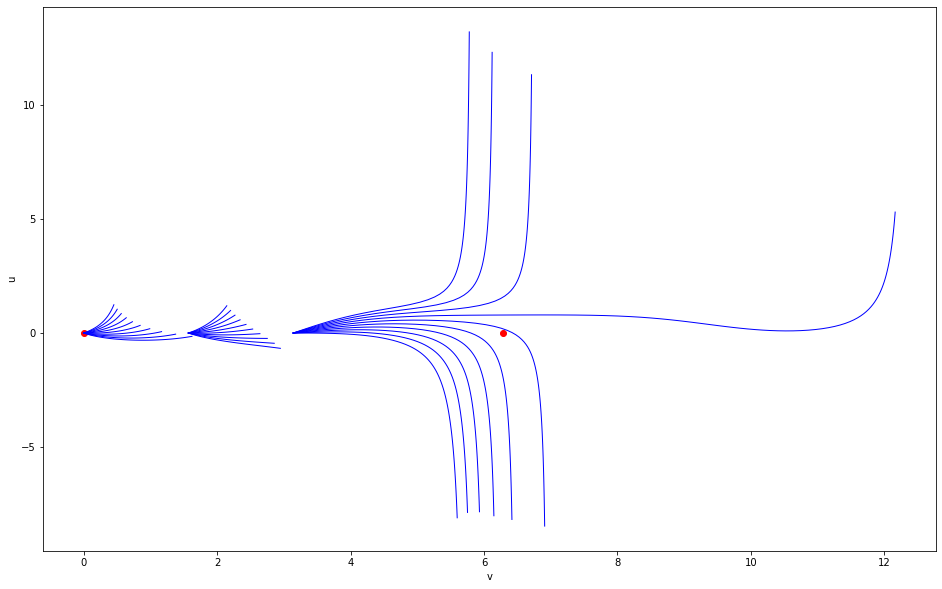

In [25]:
%matplotlib inline
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot()
ax.plot([0,2*np.pi], [0,0], 'o', color='red')
ax.set_xlabel('v')
ax.set_ylabel('u')


tmax = 1              # maximum length of line
t = np.linspace(0, tmax, 100)

for du in np.linspace(-1,1, 10):
    y0 = [0, du, 0*np.pi/4, 1] # initial  u, u', v, v', determines direction and starting point
    g = geodesic(X, u, v, y0, tmax)
    
    line = (g(t)[1], g(t)[0])
    ax.plot(*line, color='blue', linewidth=1)
    
tmax = 1              # maximum length of line
t = np.linspace(0, tmax, 100)
for du in np.linspace(-1,1, 10):
    y0 = [0, du, 2*np.pi/4, 1] # initial  u, u', v, v', determines direction and starting point
    g = geodesic(X, u, v, y0, tmax)
    
    line = (g(t)[1], g(t)[0])
    ax.plot(*line, color='blue', linewidth=1)
    
tmax = 10              # maximum length of line
t = np.linspace(0, tmax, 100)
for du in np.linspace(0,1, 10):
    y0 = [0, du, np.pi, 1] # initial  u, u', v, v', determines direction and starting point
    g = geodesic(X, u, v, y0, tmax)
    
    line = (g(t)[1], g(t)[0])
    ax.plot(*line, color='blue', linewidth=1)

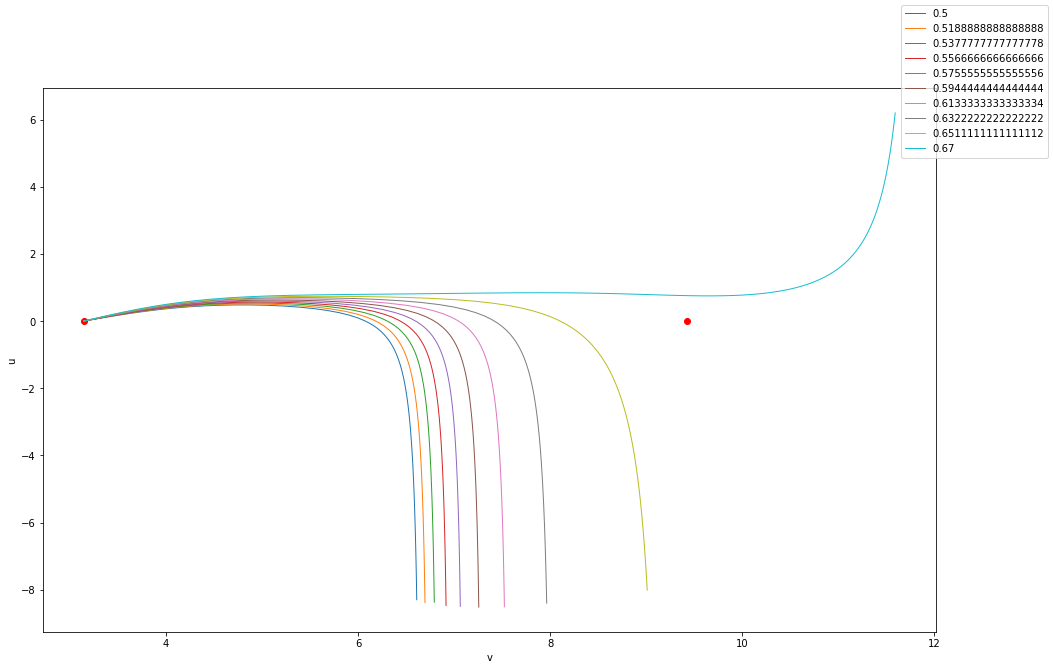

In [26]:
%matplotlib inline
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot()
ax.plot([np.pi,3*np.pi], [0,0], 'o', color='red')
ax.set_xlabel('v')
ax.set_ylabel('u')

    
tmax = 10              # maximum length of line
t = np.linspace(0, tmax, 100)
for du in np.linspace(0.5,0.67, 10):
    y0 = [0, du, np.pi, 1] # initial  u, u', v, v', determines direction and starting point
    g = geodesic(X, u, v, y0, tmax)
    
    line = (g(t)[1], g(t)[0])
    ax.plot(*line, linewidth=1, label=du)
    
fig.legend()

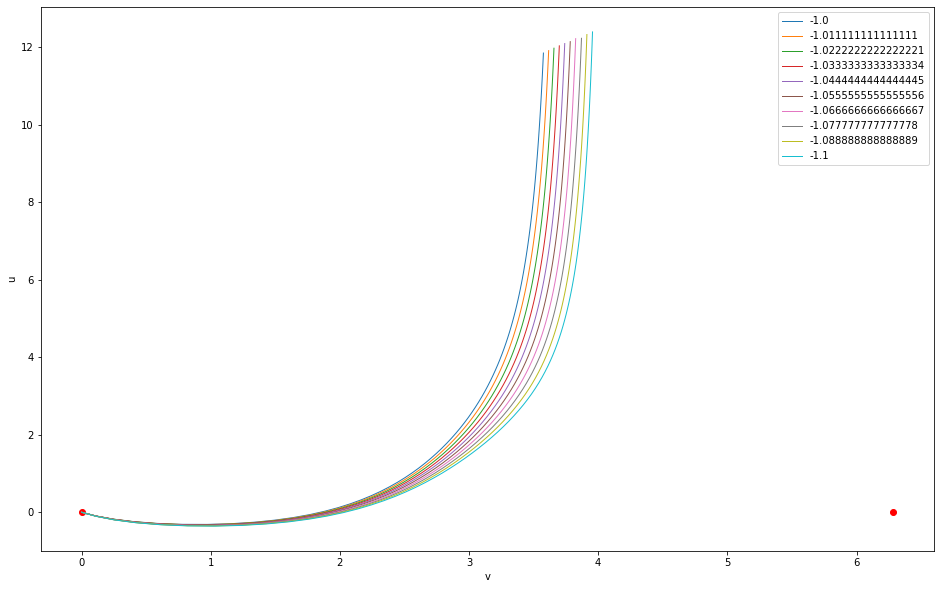

In [27]:
%matplotlib inline
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot()
ax.plot([0,2*np.pi], [0,0], 'o', color='red')
ax.set_xlabel('v')
ax.set_ylabel('u')


tmax = 10              # maximum length of line
t = np.linspace(0, tmax, 100)

for u_val in [0]: # in np.linspace(-1,0,3):
    for du in np.linspace(-1.,-1.1, 10):
        y0 = [u_val, du, 0*np.pi/4, 1] # initial  u, u', v, v', determines direction and starting point
        g = geodesic(X, u, v, y0, tmax)

        line = (g(t)[1], g(t)[0])
        ax.plot(*line, linewidth=1, label=du)
    
plt.legend()